## Device Stuff

In [134]:
import torch

#Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Dataset

In [135]:
import json
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [136]:
# Create a dataframe dataset object with all videos from .json config

def create_dataframe(json_config, videos_root):
    data = []
    videos = json.load(open(json_config))
    train, val, test = dict(), dict(), dict()
    for name in os.listdir(videos_root):
        name = name[:-4]
        if videos.get(name) is None:
            continue
        video = videos[name]
        data.append([name, video['subset'], video['action'][1], video['action'][2], video['action'][0]])
    return pd.DataFrame(data, columns=['video_name', 'subset', 'start_frame', 'end_frame', 'class_id'])

dataset = create_dataframe('output.json', 'data/raw/dataset/videos')
dataset

,video_name,subset,start_frame,end_frame,class_id
0,05727,test,1,74,3
1,05728,train,1,27,3
2,05729,train,1,45,3
3,05730,train,1,32,3
4,05731,train,1,47,3
5,05732,train,1,73,3
6,05733,train,1,92,3
7,05734,train,1,69,3
8,05739,test,1,44,3
9,05740,train,1,42,3


In [137]:
from os.path import exists
import torch.nn.functional as F

class ASLDataset(Dataset):
    """
    A custom dataset class for loading American Sign Language (ASL) videos and their corresponding labels.

    Args:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        dataset_df (DataFrame): Pandas dataframe with information about videos
        max_frame_count (int): Maximum length of video in frames.
        ohe (OneHotEncoder): Required to encode class id to one hot numeric array.

    Attributes:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        name_with_label (dict): A dictionary mapping video names to their labels.
        classes (list): A list of class names.
    """

    def __init__(self, tensors_folder: str, dataset_df: pd.DataFrame, max_frame_count: int) -> None:
        # Default frame (set of points) to insert in short videos to make all videos equal in length
        default_frame = [0] * (21 * 3 * 2 + 33 * 3)
        
        self.IDX_TO_CLASS = [ c_id for i, c_id in enumerate(set(dataset_df.class_id))]
        self.CLASS_TO_IDX = { c_id: i for i, c_id in enumerate(self.IDX_TO_CLASS)}
        
        self.tensor_sequences = []
        self.targets = []
        for i, row in dataset_df.iterrows():
            path_to_tensor = tensors_folder + '/' + row["video_name"] + '.pt'
            
            if not exists(path_to_tensor):
                continue
            
            # Open the video file using OpenCV
            tensor = torch.load(path_to_tensor)

            # Change length of video (not a video but sequence of frames with points coordinates in each frame)
            # pad_right = [default_frame for _ in range(0, max_frame_count - tensor.shape[0])]
            # pad_right = torch.tensor(pad_right)
            # self.tensor_sequences.append(torch.cat((pad_right, F.normalize(tensor.float(), dim=1))))
            self.tensor_sequences.append(F.normalize(tensor.float(), dim=1))
            self.targets.append(self.CLASS_TO_IDX[dataset_df["class_id"][i]])
        self.targets = torch.tensor(self.targets)
            
            
    def __len__(self):
        """
        Returns the number of videos in the dataset.

        Returns:
            int: The number of videos in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, index):
        """
        Retrieves a video and its corresponding label from the dataset.

        Args:
            index (int): The index of the video to retrieve.

        Returns:
            tuple: A tuple containing the video frames as a PyTorch tensor and the label.
        """

        return self.tensor_sequences[index].float(), self.targets[index].long()


In [138]:
def read_classes(path):
    classes = dict()
    with open(path, 'r') as file:
        for line in file:
            line = line.strip().split('\t')
            key = int(line[0])
            value = line[1]
            classes[key] = value
    return classes

In [139]:
max_frame_count = max(dataset["end_frame"] - dataset["start_frame"] + 1)
print(f"Maximum length of video in frames in current dataset is {max_frame_count}")

Maximum length of video in frames in current dataset is 101


In [160]:
train = dataset[dataset["subset"] == "train"]
#val = dataset[dataset["subset"] == "val"]
test = dataset[(dataset["subset"] == "test") | (dataset["subset"] == "val")]
classes = read_classes('data/raw/dataset/wlasl_class_list.txt')

train_dataset = ASLDataset('data/internal/features', train, max_frame_count)
#val_dataset = ASLDataset('data/internal/features', val, max_frame_count)
test_dataset = ASLDataset('data/internal/features', test, max_frame_count)

In [161]:
train_dataset[1]

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.2254, -0.1015,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.2097, -0.0235,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.2169, -0.0138,  0.0000],
         ...,
         [ 0.0459,  0.0641,  0.0000,  ...,  0.1674,  0.0330,  0.0000],
         [ 0.0481,  0.0671,  0.0000,  ...,  0.1684,  0.0499,  0.0000],
         [ 0.0545,  0.0763,  0.0000,  ...,  0.1838,  0.0345,  0.0000]]),
 tensor(0))

In [162]:
# Create dataloaders
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
#print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 23
Test size: 9


## Model

In [163]:
import torch.nn as nn

class SequenceModel(nn.Module):
    def __init__(self, input_size=1662, output_size=100) -> None:
        super().__init__()
        self.lstm = nn.Sequential(
            nn.LSTM(input_size, 64, 1, batch_first=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])

        return x

In [164]:
model = SequenceModel(input_size=225, output_size=2)
model.to(device)

SequenceModel(
  (lstm): Sequential(
    (0): LSTM(225, 64, batch_first=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

## Training

In [165]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm


def train_model(model: nn.Module, epochs: int, criterion, optimizer, ckpt_path='models/best.pt'):
    """
    Function that trains model using number of epochs, loss function, optimizer.
    Can use validation or test data set for evaluation.
    Calculates f1 score.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    epochs: int
      Number of train epochs
    criterion
      The loss function from pytorch
    optimizer
      The optimizer from pytorch
    """
    
    model.train()
    model.to(device)
    
    history = {'train_losses': [], 'test_losses': [], 'train_scores': [], 'test_scores': []}

    # Train the model
    for epoch in range(epochs):
        model.train()

        predicted_train = []
        true_train = []

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for inputs, targets in bar:
            inputs, targets = inputs.to(device), targets.to(device)
          
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_train.append(item.cpu().numpy())
            for item in targets:
                true_train.append(item.cpu().numpy())
            iterations += 1
            bar.set_postfix(({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataset)
        # Computing f1 score
        train_f1 = f1_score(true_train, predicted_train, average="macro")
        

        # Printing information in the end of train loop
        test_loss, test_f1 = test_model(model, criterion, test_dataloader)
        
        
        history['train_losses'].append(train_loss)
        history['test_losses'].append(test_loss)
        history['train_scores'].append(train_f1)
        history['test_scores'].append(test_f1)
        
        if test_f1 > max(history['test_scores']):
                torch.save(model.state_dict(), ckpt_path)
        
        print(f"Epoch {epoch+1} train (loss: {train_loss:.4f}, f1 score: {train_f1:.4f}) test (loss: {test_loss:.4f}, f1 score: {test_f1:.4f})")
    
    return history
      


def test_model(model: nn.Module, criterion, test_dataloader: DataLoader):
    """
    Function that evaluates model on specified dataloader
    by specified loss function.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    criterion
      The loss function from pytorch
    test_dataloader: DataLoader
      The dataset for testing model

    Returns
    -------
    float: loss of model on given dataset
    float: f1 score of model on given dataset
    """

    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    # Lists for calculation f1 score
    predicted_test = []
    true_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_test.append(item.cpu().numpy())
            for item in targets:
                true_test.append(item.cpu().numpy())

    # Computation of test loss
    test_loss /= len(test_dataloader)

    # Computation of f1 score
    test_f1 = f1_score(true_test, predicted_test, average="macro")
    return test_loss.item(), test_f1


In [166]:
model = SequenceModel(input_size=225, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [167]:
history = train_model(model, 100, criterion, optimizer, ckpt_path='models/simple_lstm/best.pt')

100%|██████████| 23/23 [00:00<00:00, 59.32it/s, loss=0.6952354000962299]


Epoch 1 train (loss: 0.6952, f1 score: 0.3429) test (loss: 0.7046, f1 score: 0.3077)


100%|██████████| 23/23 [00:00<00:00, 81.30it/s, loss=0.6911855365919031]


Epoch 2 train (loss: 0.6912, f1 score: 0.3429) test (loss: 0.7023, f1 score: 0.3077)


100%|██████████| 23/23 [00:00<00:00, 79.55it/s, loss=0.6932085519251616]


Epoch 3 train (loss: 0.6932, f1 score: 0.3429) test (loss: 0.7046, f1 score: 0.3077)


100%|██████████| 23/23 [00:00<00:00, 68.67it/s, loss=0.6877674279005631]


Epoch 4 train (loss: 0.6878, f1 score: 0.3429) test (loss: 0.7003, f1 score: 0.3077)


100%|██████████| 23/23 [00:00<00:00, 55.19it/s, loss=0.6862817251163981]


Epoch 5 train (loss: 0.6863, f1 score: 0.3429) test (loss: 0.7014, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 55.95it/s, loss=0.6847574218459751]


Epoch 6 train (loss: 0.6848, f1 score: 0.4363) test (loss: 0.7068, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 70.98it/s, loss=0.6804260559703993]


Epoch 7 train (loss: 0.6804, f1 score: 0.6933) test (loss: 0.7262, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 72.23it/s, loss=0.679043596205504] 


Epoch 8 train (loss: 0.6790, f1 score: 0.4866) test (loss: 0.7097, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 74.60it/s, loss=0.6438137448352316]


Epoch 9 train (loss: 0.6438, f1 score: 0.6462) test (loss: 0.7644, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 63.61it/s, loss=0.6358285611090453]


Epoch 10 train (loss: 0.6358, f1 score: 0.7386) test (loss: 0.8269, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 76.32it/s, loss=0.6250296649725541]


Epoch 11 train (loss: 0.6250, f1 score: 0.6862) test (loss: 0.7467, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 69.27it/s, loss=0.544544738271962] 


Epoch 12 train (loss: 0.5445, f1 score: 0.7810) test (loss: 1.1094, f1 score: 0.1818)


100%|██████████| 23/23 [00:00<00:00, 68.63it/s, loss=0.8027878034373989]


Epoch 13 train (loss: 0.8028, f1 score: 0.5437) test (loss: 0.7086, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 66.13it/s, loss=0.6719244886999545]


Epoch 14 train (loss: 0.6719, f1 score: 0.4103) test (loss: 0.7009, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 65.69it/s, loss=0.6540250881858494]


Epoch 15 train (loss: 0.6540, f1 score: 0.6734) test (loss: 0.7029, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 87.50it/s, loss=0.6250189503897792]


Epoch 16 train (loss: 0.6250, f1 score: 0.6057) test (loss: 0.7268, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 86.09it/s, loss=0.6309552983097408]


Epoch 17 train (loss: 0.6310, f1 score: 0.6515) test (loss: 0.7238, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 81.17it/s, loss=0.6001407167185908]


Epoch 18 train (loss: 0.6001, f1 score: 0.6862) test (loss: 0.7347, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 83.22it/s, loss=0.5545866107163222]


Epoch 19 train (loss: 0.5546, f1 score: 0.8175) test (loss: 0.8232, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 83.87it/s, loss=0.524800348541011]  


Epoch 20 train (loss: 0.5248, f1 score: 0.7125) test (loss: 0.9270, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 84.03it/s, loss=0.5444268610166467]


Epoch 21 train (loss: 0.5444, f1 score: 0.7262) test (loss: 0.8666, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 55.93it/s, loss=0.5987107416857844]


Epoch 22 train (loss: 0.5987, f1 score: 0.5175) test (loss: 0.7431, f1 score: 0.3077)


100%|██████████| 23/23 [00:00<00:00, 56.18it/s, loss=0.585043073348377] 


Epoch 23 train (loss: 0.5850, f1 score: 0.5548) test (loss: 0.7416, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 60.36it/s, loss=0.7018174990687681]


Epoch 24 train (loss: 0.7018, f1 score: 0.7758) test (loss: 0.8361, f1 score: 0.5846)


100%|██████████| 23/23 [00:00<00:00, 68.80it/s, loss=0.7734928179694258]


Epoch 25 train (loss: 0.7735, f1 score: 0.4866) test (loss: 1.1127, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 62.64it/s, loss=0.6216663335976393]


Epoch 26 train (loss: 0.6217, f1 score: 0.6957) test (loss: 0.9610, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 94.91it/s, loss=0.5602238476276398]


Epoch 27 train (loss: 0.5602, f1 score: 0.7810) test (loss: 0.9790, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 68.83it/s, loss=0.5418412996375043]


Epoch 28 train (loss: 0.5418, f1 score: 0.7810) test (loss: 0.9345, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 46.44it/s, loss=0.495824726379436]  


Epoch 29 train (loss: 0.4958, f1 score: 0.8231) test (loss: 1.1122, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 80.48it/s, loss=0.5030940913635752]


Epoch 30 train (loss: 0.5031, f1 score: 0.7667) test (loss: 1.0415, f1 score: 0.4444)


100%|██████████| 23/23 [00:00<00:00, 81.04it/s, loss=0.5592991648160893] 


Epoch 31 train (loss: 0.5593, f1 score: 0.7262) test (loss: 1.0789, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 56.26it/s, loss=0.4738173640292624] 


Epoch 32 train (loss: 0.4738, f1 score: 0.7667) test (loss: 0.8837, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 65.55it/s, loss=0.7555928745347521]


Epoch 33 train (loss: 0.7556, f1 score: 0.4559) test (loss: 0.7678, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 76.40it/s, loss=0.7007765731085902]


Epoch 34 train (loss: 0.7008, f1 score: 0.3235) test (loss: 0.7152, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 75.31it/s, loss=0.6774553695450658]


Epoch 35 train (loss: 0.6775, f1 score: 0.3235) test (loss: 0.7128, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 82.92it/s, loss=0.6753169751685598]


Epoch 36 train (loss: 0.6753, f1 score: 0.3235) test (loss: 0.7107, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 74.90it/s, loss=0.6686664988165316]


Epoch 37 train (loss: 0.6687, f1 score: 0.4866) test (loss: 0.7116, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 88.64it/s, loss=0.6614125306191652]


Epoch 38 train (loss: 0.6614, f1 score: 0.4866) test (loss: 0.7152, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 93.55it/s, loss=0.6518735781959866]


Epoch 39 train (loss: 0.6519, f1 score: 0.5548) test (loss: 0.7221, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 85.89it/s, loss=0.642809914506]    


Epoch 40 train (loss: 0.6428, f1 score: 0.6862) test (loss: 0.7252, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 76.09it/s, loss=0.632649504620096] 


Epoch 41 train (loss: 0.6326, f1 score: 0.7262) test (loss: 0.7386, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 106.02it/s, loss=0.6315971885038458]


Epoch 42 train (loss: 0.6316, f1 score: 0.7346) test (loss: 0.7402, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 87.30it/s, loss=0.6056122313375059] 


Epoch 43 train (loss: 0.6056, f1 score: 0.7346) test (loss: 0.7596, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 52.64it/s, loss=0.6184268166189608]


Epoch 44 train (loss: 0.6184, f1 score: 0.6933) test (loss: 0.7731, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 55.58it/s, loss=0.5844927456067956]


Epoch 45 train (loss: 0.5845, f1 score: 0.6862) test (loss: 0.7940, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 60.15it/s, loss=0.5763543150995089]


Epoch 46 train (loss: 0.5764, f1 score: 0.7826) test (loss: 0.8225, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 75.37it/s, loss=0.6017331856748332]


Epoch 47 train (loss: 0.6017, f1 score: 0.6734) test (loss: 0.7815, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 76.76it/s, loss=0.5392660576364269]


Epoch 48 train (loss: 0.5393, f1 score: 0.8258) test (loss: 0.7804, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 72.21it/s, loss=0.5683897928051327]


Epoch 49 train (loss: 0.5684, f1 score: 0.7346) test (loss: 0.8308, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 83.42it/s, loss=0.5103645975822988] 


Epoch 50 train (loss: 0.5104, f1 score: 0.8231) test (loss: 0.8537, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 87.96it/s, loss=0.4991670989471933] 


Epoch 51 train (loss: 0.4992, f1 score: 0.6957) test (loss: 0.8670, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 70.14it/s, loss=0.45828010595363117]


Epoch 52 train (loss: 0.4583, f1 score: 0.7810) test (loss: 0.6117, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 79.21it/s, loss=0.7041824077782424]


Epoch 53 train (loss: 0.7042, f1 score: 0.5965) test (loss: 0.7211, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 67.03it/s, loss=0.5951247837232507]


Epoch 54 train (loss: 0.5951, f1 score: 0.5801) test (loss: 0.7224, f1 score: 0.3250)


100%|██████████| 23/23 [00:00<00:00, 68.27it/s, loss=0.5717527037081511]


Epoch 55 train (loss: 0.5718, f1 score: 0.7386) test (loss: 0.7437, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 77.20it/s, loss=0.4857429324284844] 


Epoch 56 train (loss: 0.4857, f1 score: 0.8258) test (loss: 0.7790, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 78.48it/s, loss=0.45230317958023236]


Epoch 57 train (loss: 0.4523, f1 score: 0.7826) test (loss: 0.8258, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 74.56it/s, loss=0.4301622675164886] 


Epoch 58 train (loss: 0.4302, f1 score: 0.7810) test (loss: 0.8464, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 76.06it/s, loss=0.42458222612090735]


Epoch 59 train (loss: 0.4246, f1 score: 0.8231) test (loss: 0.8247, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 64.20it/s, loss=0.3849051416568134] 


Epoch 60 train (loss: 0.3849, f1 score: 0.8686) test (loss: 0.9281, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 74.93it/s, loss=0.36500904579525406]


Epoch 61 train (loss: 0.3650, f1 score: 0.8258) test (loss: 0.9383, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 57.54it/s, loss=0.38310629404757335]


Epoch 62 train (loss: 0.3831, f1 score: 0.8258) test (loss: 1.0137, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 76.87it/s, loss=0.37450756642805494]


Epoch 63 train (loss: 0.3745, f1 score: 0.8258) test (loss: 0.8182, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 54.39it/s, loss=0.4384281219023725] 


Epoch 64 train (loss: 0.4384, f1 score: 0.8258) test (loss: 1.5006, f1 score: 0.2500)


100%|██████████| 23/23 [00:00<00:00, 58.96it/s, loss=0.631921507742094] 


Epoch 65 train (loss: 0.6319, f1 score: 0.7125) test (loss: 1.0282, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 63.33it/s, loss=0.42344749192504777]


Epoch 66 train (loss: 0.4234, f1 score: 0.8258) test (loss: 0.9529, f1 score: 0.6667)


100%|██████████| 23/23 [00:00<00:00, 73.37it/s, loss=0.4249942424180715] 


Epoch 67 train (loss: 0.4250, f1 score: 0.7826) test (loss: 0.9582, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 85.82it/s, loss=0.3657006047990011] 


Epoch 68 train (loss: 0.3657, f1 score: 0.8686) test (loss: 1.0346, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 73.67it/s, loss=0.33759688739867316]


Epoch 69 train (loss: 0.3376, f1 score: 0.8686) test (loss: 1.0452, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 80.17it/s, loss=0.3831978817672833] 


Epoch 70 train (loss: 0.3832, f1 score: 0.7810) test (loss: 0.9985, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 79.40it/s, loss=0.33535353369686915]


Epoch 71 train (loss: 0.3354, f1 score: 0.8686) test (loss: 0.9912, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 72.60it/s, loss=0.31710065431568935]


Epoch 72 train (loss: 0.3171, f1 score: 0.8686) test (loss: 1.0854, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 72.32it/s, loss=0.31213756480618665]


Epoch 73 train (loss: 0.3121, f1 score: 0.8686) test (loss: 1.2000, f1 score: 0.6667)


100%|██████████| 23/23 [00:00<00:00, 58.71it/s, loss=0.4544310142974491] 


Epoch 74 train (loss: 0.4544, f1 score: 0.7826) test (loss: 1.0133, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 63.25it/s, loss=0.30751299250708974]


Epoch 75 train (loss: 0.3075, f1 score: 0.8686) test (loss: 1.0524, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 64.32it/s, loss=0.37967958916788513]


Epoch 76 train (loss: 0.3797, f1 score: 0.8258) test (loss: 1.1341, f1 score: 0.5846)


100%|██████████| 23/23 [00:00<00:00, 68.96it/s, loss=0.30843112577238807]


Epoch 77 train (loss: 0.3084, f1 score: 0.8686) test (loss: 1.0598, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 73.70it/s, loss=0.3006698108156738] 


Epoch 78 train (loss: 0.3007, f1 score: 0.8696) test (loss: 1.1306, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 83.06it/s, loss=0.2924035834148526] 


Epoch 79 train (loss: 0.2924, f1 score: 0.8686) test (loss: 1.2112, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 86.42it/s, loss=0.29648770497221016]


Epoch 80 train (loss: 0.2965, f1 score: 0.9129) test (loss: 1.0871, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 86.75it/s, loss=0.25936205794467876]


Epoch 81 train (loss: 0.2594, f1 score: 0.8686) test (loss: 1.1002, f1 score: 0.6667)


100%|██████████| 23/23 [00:00<00:00, 94.81it/s, loss=0.30710424363370176]


Epoch 82 train (loss: 0.3071, f1 score: 0.8686) test (loss: 1.3421, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 84.21it/s, loss=0.22006815599034663]


Epoch 83 train (loss: 0.2201, f1 score: 0.9115) test (loss: 1.3839, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 73.57it/s, loss=0.340702914086211]  


Epoch 84 train (loss: 0.3407, f1 score: 0.9129) test (loss: 1.1429, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 66.03it/s, loss=0.28661461243324954]


Epoch 85 train (loss: 0.2866, f1 score: 0.9115) test (loss: 1.2277, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 75.62it/s, loss=0.3148341901681345] 


Epoch 86 train (loss: 0.3148, f1 score: 0.8231) test (loss: 1.2552, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 81.08it/s, loss=0.4655883062792861] 


Epoch 87 train (loss: 0.4656, f1 score: 0.7758) test (loss: 1.0724, f1 score: 0.6667)


100%|██████████| 23/23 [00:00<00:00, 76.69it/s, loss=0.3584430323832709] 


Epoch 88 train (loss: 0.3584, f1 score: 0.8655) test (loss: 1.0574, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 76.71it/s, loss=0.28705090936273336]


Epoch 89 train (loss: 0.2871, f1 score: 0.8686) test (loss: 1.1429, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 72.59it/s, loss=0.25552749313900003]


Epoch 90 train (loss: 0.2555, f1 score: 0.8696) test (loss: 1.4197, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 66.61it/s, loss=0.47735090096197696]


Epoch 91 train (loss: 0.4774, f1 score: 0.7758) test (loss: 0.9802, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 62.93it/s, loss=0.36792779252257035]


Epoch 92 train (loss: 0.3679, f1 score: 0.8686) test (loss: 1.0028, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 71.06it/s, loss=0.40448551131007465]


Epoch 93 train (loss: 0.4045, f1 score: 0.7346) test (loss: 1.0368, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 63.08it/s, loss=0.3567724826786181] 


Epoch 94 train (loss: 0.3568, f1 score: 0.8231) test (loss: 1.0652, f1 score: 0.5000)


100%|██████████| 23/23 [00:00<00:00, 74.03it/s, loss=0.2941388584997343] 


Epoch 95 train (loss: 0.2941, f1 score: 0.8258) test (loss: 1.1332, f1 score: 0.5500)


100%|██████████| 23/23 [00:00<00:00, 79.92it/s, loss=0.2588209750373726] 


Epoch 96 train (loss: 0.2588, f1 score: 0.8258) test (loss: 1.2259, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 83.92it/s, loss=0.2900502686591252] 


Epoch 97 train (loss: 0.2901, f1 score: 0.8696) test (loss: 1.3036, f1 score: 0.6667)


100%|██████████| 23/23 [00:00<00:00, 81.23it/s, loss=0.2703980346939162] 


Epoch 98 train (loss: 0.2704, f1 score: 0.8258) test (loss: 1.2855, f1 score: 0.4156)


100%|██████████| 23/23 [00:00<00:00, 95.87it/s, loss=0.20259622753719272]


Epoch 99 train (loss: 0.2026, f1 score: 0.9115) test (loss: 1.5603, f1 score: 0.3571)


100%|██████████| 23/23 [00:00<00:00, 92.85it/s, loss=0.6457983047458464]


Epoch 100 train (loss: 0.6458, f1 score: 0.5548) test (loss: 1.0816, f1 score: 0.4156)


In [175]:
print(f"Best F1 score: {max(history['test_scores'])}")

Best F1 score: 0.6666666666666665


# Results visualization

In [168]:
from matplotlib import pyplot as plt

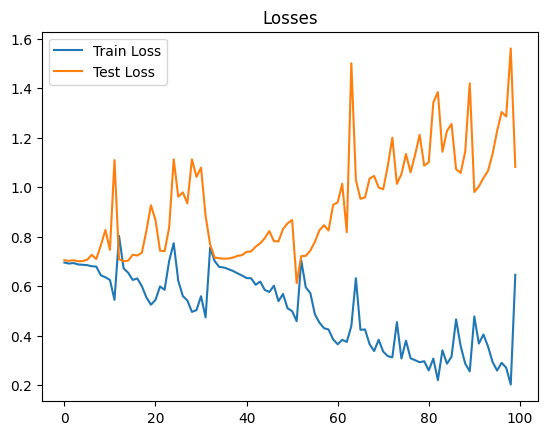

In [180]:
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.title("Losses")
plt.legend()
plt.show()

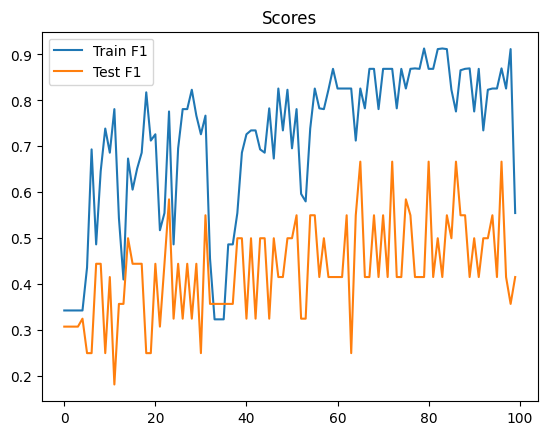

In [181]:
plt.plot(history['train_scores'], label="Train F1")
plt.plot(history['test_scores'], label="Test F1")
plt.title("Scores")
plt.legend()
plt.show()